## **Dataset Characteristics**

In this Jupyter notebook, we explain the cleaning of the given dataset and the evaluation of the entire cleaned dataset including added features.

Cleaned dataset excludes dates without weathercode as we assume that weather might have an inpiuut in the sales.

To get an overview, we analysed the dataset first :
General overview - 'Warengruppe', we uses a bar chart with confidence intervals to display the relationship between the average sales per day of the week. The days of the week in the chart are sorted from Monday to Sunday. In addition, we examined each 'Warengruppe' on its own. However, 'Warengruppe Saisonbrot' needed some furhter investigation as the product has been for sale only for certain time periods (resulting in being taken out for the modelling).

In addition, we checked for days without any sales at all (most likely the shop was closed ;-)

### **0 - Import the file**

In [44]:
# Import the necessary libaries
import csv
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
import missingno as msno
import seaborn as sns

# Read the file and check it out
# df = pd.read_csv(r'/Users/jberndt/Desktop/2-2-opencampus/X-opencampus_ML/2_DS_and_ML/5-homework_week05/z-data_sorted-v1/5_has_wettercode.csv')

# Correct URL
url = 'https://raw.githubusercontent.com/BossyNine/bakery_sales_prediction/main/sourcedata/cleaned_data/5_has_wettercode.csv'

# Read the file and check it out
df = pd.read_csv(url)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                7009 non-null   object 
 1   Bewoelkung           7009 non-null   float64
 2   Temperatur           7009 non-null   float64
 3   Windgeschwindigkeit  7009 non-null   float64
 4   Wettercode           7009 non-null   float64
 5   KielerWoche          7009 non-null   float64
 6   Warengruppe          7009 non-null   float64
 7   Umsatz               7009 non-null   float64
 8   Feiertage            7009 non-null   float64
 9   Ferientage           7009 non-null   float64
dtypes: float64(9), object(1)
memory usage: 547.7+ KB


,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Warengruppe,Umsatz,Feiertage,Ferientage
0,2013-07-01,6.0,17.8375,15.0,20.0,0.0,1.0,148.828353,0.0,1.0
1,2013-07-01,6.0,17.8375,15.0,20.0,0.0,2.0,535.856285,0.0,1.0
2,2013-07-01,6.0,17.8375,15.0,20.0,0.0,3.0,201.198426,0.0,1.0
3,2013-07-01,6.0,17.8375,15.0,20.0,0.0,4.0,65.890169,0.0,1.0
4,2013-07-01,6.0,17.8375,15.0,20.0,0.0,5.0,317.475875,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
7004,2018-07-30,6.0,27.7875,10.0,21.0,0.0,1.0,148.541340,0.0,1.0
7005,2018-07-30,6.0,27.7875,10.0,21.0,0.0,2.0,616.358562,0.0,1.0
7006,2018-07-30,6.0,27.7875,10.0,21.0,0.0,3.0,348.770346,0.0,1.0
7007,2018-07-30,6.0,27.7875,10.0,21.0,0.0,4.0,71.822977,0.0,1.0


### **1 - Creation of a bar chart: representation of the correlation of average sales per weekday (sorted from Monday to Sunday inclusive) and adding the confidence intervals of sales per weekday (using standard deviation of sales per weekday)**

To analyse the dataset only for each 'Warengruppe', we uses a bar chart with confidence intervals to display the relationship between the  
average sales per day of the week. The days of the week in the chart are sorted from Monday to Sunday.

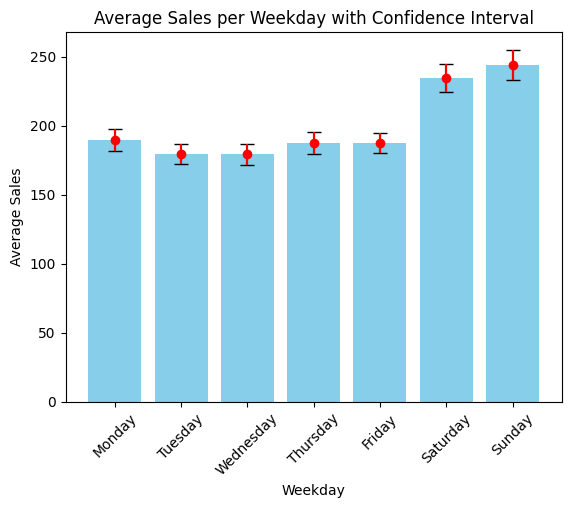

In [45]:
# Convert 'Datum' column to datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

# Extract weekday from 'Datum' column
df['Weekday'] = df['Datum'].dt.weekday

# Calculate average sales per weekday
avg_sales_per_weekday = df.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df.groupby('Weekday')['Umsatz'].std() / np.sqrt(df.groupby('Weekday')['Umsatz'].count())

# Plot bar chart
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales')
plt.title('Average Sales per Weekday with Confidence Interval')
plt.show()
logging.info(avg_sales_per_weekday)

### **2 - List/Analyze the  column "Warengruppe"**

In [46]:
# Correct URL
url = 'https://raw.githubusercontent.com/BossyNine/bakery_sales_prediction/main/sourcedata/cleaned_data/5_has_wettercode.csv'

# Read the file and check it out
df_warengruppe = pd.read_csv(url)

# Convert the 'Warengruppe' column to strings
df_warengruppe['Warengruppe'] = df_warengruppe['Warengruppe'].astype(str)

# Split the 'Warengruppe' column into six new columns
df_warengruppe = pd.concat([df_warengruppe, pd.get_dummies(df_warengruppe['Warengruppe'], prefix='Warengruppe')], axis=1)

# Drop the 'Warengruppe' column as it's no longer needed
df_warengruppe.drop('Warengruppe', axis=1, inplace=True)

# Rename the new columns
df_warengruppe.rename(columns={'Warengruppe_1.0': 'Brot', 'Warengruppe_2.0': 'Broetchen', 'Warengruppe_3.0': 'Croissant', 'Warengruppe_4.0': 'Konditorei', 'Warengruppe_5.0': 'Kuchen', 'Warengruppe_6.0': 'Saisonbrot'}, inplace=True)

# Save the new DataFrame into a new CSV file
df_warengruppe.to_csv('5-1_has_wettercode_single_warengruppen.csv', index=False)

# Show the new file

# Save the new DataFrame into a new CSV file
df_warengruppe.to_csv('5-1_has_wettercode_single_warengruppen.csv', index=False)


#### **2.0 - List/Analyze the new columns for "Warengruppe"**

In [47]:
# Correct URL for the new file
url_new = 'https://raw.githubusercontent.com/BossyNine/bakery_sales_prediction/main/sourcedata/cleaned_data/5-1_has_wettercode_single_warengruppen.csv'

# Read the file and check it out
df_warengruppe_new = pd.read_csv(url_new)

df_warengruppe_new.info()
print(df_warengruppe_new.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009 entries, 0 to 7008
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                7009 non-null   object 
 1   Bewoelkung           7009 non-null   float64
 2   Temperatur           7009 non-null   float64
 3   Windgeschwindigkeit  7009 non-null   float64
 4   Wettercode           7009 non-null   float64
 5   KielerWoche          7009 non-null   float64
 6   Umsatz               7009 non-null   float64
 7   Feiertage            7009 non-null   float64
 8   Ferientage           7009 non-null   float64
 9   Brot                 7009 non-null   int64  
 10  Broetchen            7009 non-null   int64  
 11  Croissant            7009 non-null   int64  
 12  Konditorei           7009 non-null   int64  
 13  Kuchen               7009 non-null   int64  
 14  Saisonbrot           7009 non-null   int64  
dtypes: float64(8), int64(6), object(1)
mem

#### **2.1 - List/Analyze the  column "Warengruppe - *Brot*"**

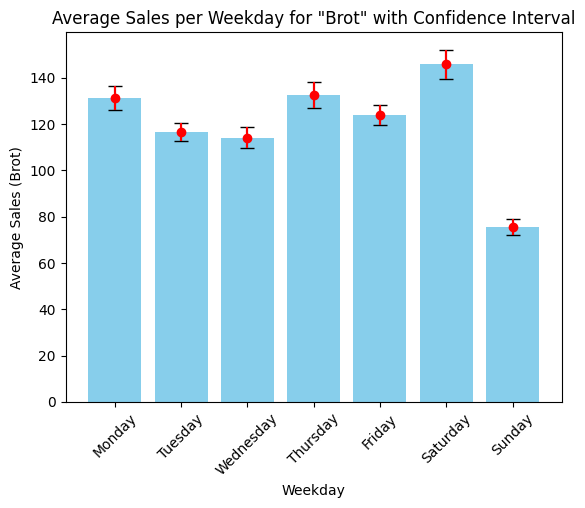

In [48]:
# Filter the DataFrame to keep only the rows where 'Brot' equals 1
df_brot = df_warengruppe_new[df_warengruppe_new['Brot'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_brot['Datum'] = pd.to_datetime(df_brot['Datum'])

# Extract weekday from 'Datum' column in place
df_brot['Weekday'] = df_brot['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Brot' column
avg_sales_per_weekday = df_brot.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df_brot.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_brot.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Brot' column
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Brot)')
plt.title('Average Sales per Weekday for "Brot" with Confidence Interval')
plt.show()

# Assign the modified DataFrame back to the variable `df_brot`
df_brot = df_brot.reset_index(drop=True)

# Print the updated DataFrame
# print(df_brot.head())
# logging.info(avg_sales_per_weekday)

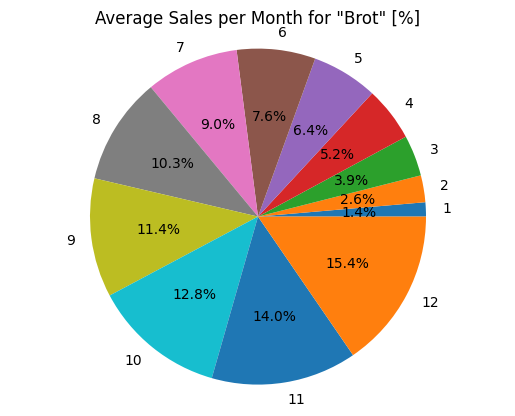

In [49]:
# Filter the DataFrame to keep only the rows where 'Brot' equals 1
df_brot = df_warengruppe_new[df_warengruppe_new['Brot'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_brot['Datum'] = pd.to_datetime(df_brot['Datum'])

# Extract month from 'Datum' column
df_brot['Month'] = df_brot['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_brot.groupby('Month')['Umsatz'].sum().cumsum().div(df_brot['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Brot" [%]')
plt.show()

#### **2.2 - List/Analyze the  column "Warengruppe - *Broetchen*"**

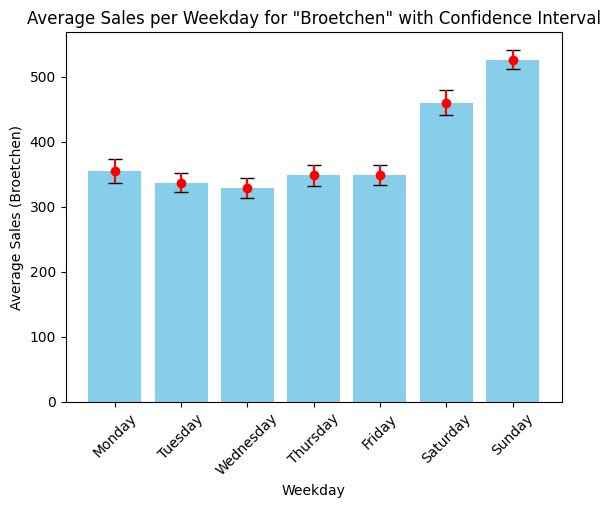

In [50]:
# Filter the DataFrame to keep only the rows where 'Brot' equals 1
df_broetchen = df_warengruppe_new[df_warengruppe_new['Broetchen'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_broetchen['Datum'] = pd.to_datetime(df_broetchen['Datum'])

# Extract weekday from 'Datum' column in place
df_broetchen['Weekday'] = df_broetchen['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Brot' column
avg_sales_per_weekday = df_broetchen.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df_broetchen.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_broetchen.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Broetchen' column
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Broetchen)')
plt.title('Average Sales per Weekday for "Broetchen" with Confidence Interval')
plt.show()

# Assign the modified DataFrame back to the variable `df_brot`
df_broetchen = df_broetchen.reset_index(drop=True)

# Print the updated DataFrame
# print(df_broetchen.head())
# logging.info(avg_sales_per_weekday)

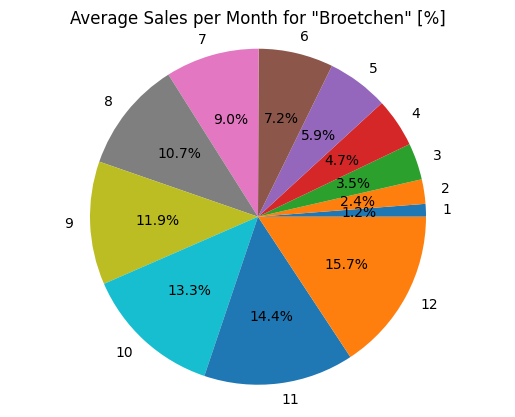

In [51]:
# Filter the DataFrame to keep only the rows where 'Broetchen' equals 1
df_broetchen = df_warengruppe_new[df_warengruppe_new['Broetchen'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_broetchen['Datum'] = pd.to_datetime(df_broetchen['Datum'])

# Extract month from 'Datum' column
df_broetchen['Month'] = df_broetchen['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_broetchen.groupby('Month')['Umsatz'].sum().cumsum().div(df_broetchen['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Broetchen" [%]')
plt.show()

#### **2.3 - List/Analyze the  column "Warengruppe - *Croissant*"**

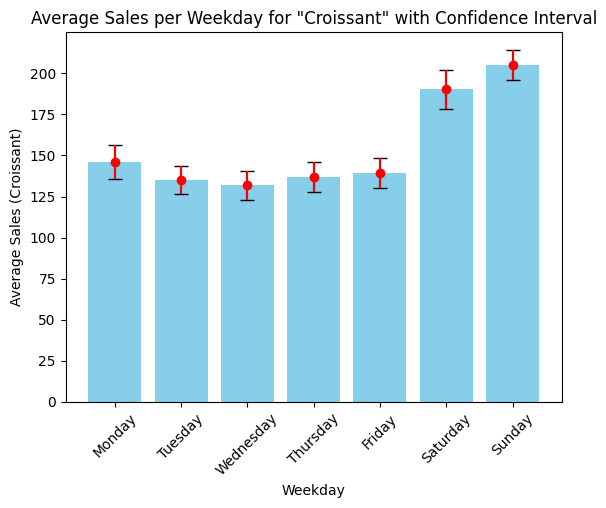

In [52]:
# Filter the DataFrame to keep only the rows where 'Croissant' equals 1
df_croissant = df_warengruppe_new[df_warengruppe_new['Croissant'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_croissant['Datum'] = pd.to_datetime(df_croissant['Datum'])

# Extract weekday from 'Datum' column in place
df_croissant['Weekday'] = df_croissant['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Croissant' column
avg_sales_per_weekday = df_croissant.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df_croissant.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_croissant.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Croissant' column
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Croissant)')
plt.title('Average Sales per Weekday for "Croissant" with Confidence Interval')
plt.show()

# Assign the modified DataFrame back to the variable `df_brot`
df_croissant = df_croissant.reset_index(drop=True)

# Print the updated DataFrame
# print(df_croissant.head())
# logging.info(avg_sales_per_weekday)

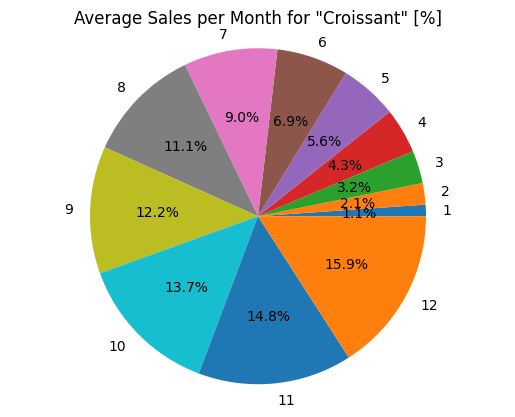

In [53]:
# Filter the DataFrame to keep only the rows where 'Croissant' equals 1
df_croissant = df_warengruppe_new[df_warengruppe_new['Croissant'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_croissant['Datum'] = pd.to_datetime(df_croissant['Datum'])

# Extract month from 'Datum' column
df_croissant['Month'] = df_croissant['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_croissant.groupby('Month')['Umsatz'].sum().cumsum().div(df_croissant['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Croissant" [%]')
plt.show()

#### **2.4 - List/Analyze the  column "Warengruppe - *Konditorei*"**

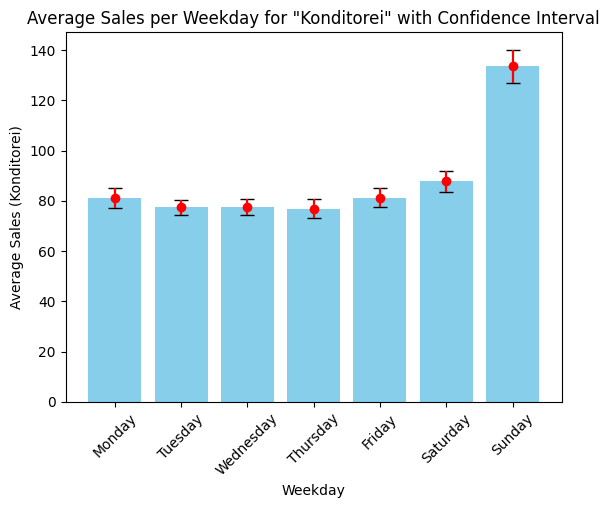

In [54]:
# Filter the DataFrame to keep only the rows where 'Konditorei' equals 1
df_konditorei = df_warengruppe_new[df_warengruppe_new['Konditorei'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_konditorei['Datum'] = pd.to_datetime(df_konditorei['Datum'])

# Extract weekday from 'Datum' column in place
df_konditorei['Weekday'] = df_konditorei['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Brot' column
avg_sales_per_weekday = df_konditorei.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df_konditorei.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_konditorei.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Brot' column
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Konditorei)')
plt.title('Average Sales per Weekday for "Konditorei" with Confidence Interval')
plt.show()

# Assign the modified DataFrame back to the variable `df_konditorei`
df_konditorei = df_konditorei.reset_index(drop=True)

# Print the updated DataFrame
# print(df_konditorei.head())
# logging.info(avg_sales_per_weekday)

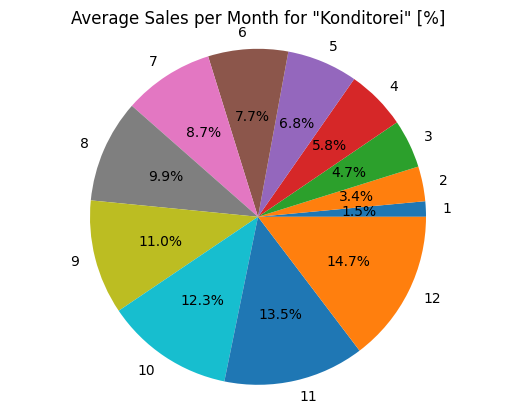

In [55]:
# Filter the DataFrame to keep only the rows where 'Konditorei' equals 1
df_konditorei = df_warengruppe_new[df_warengruppe_new['Konditorei'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_konditorei['Datum'] = pd.to_datetime(df_konditorei['Datum'])

# Extract month from 'Datum' column
df_konditorei['Month'] = df_konditorei['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_konditorei.groupby('Month')['Umsatz'].sum().cumsum().div(df_konditorei['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Konditorei" [%]')
plt.show()

#### **2.5 - List/Analyze the  column "Warengruppe - *Kuchen*"**

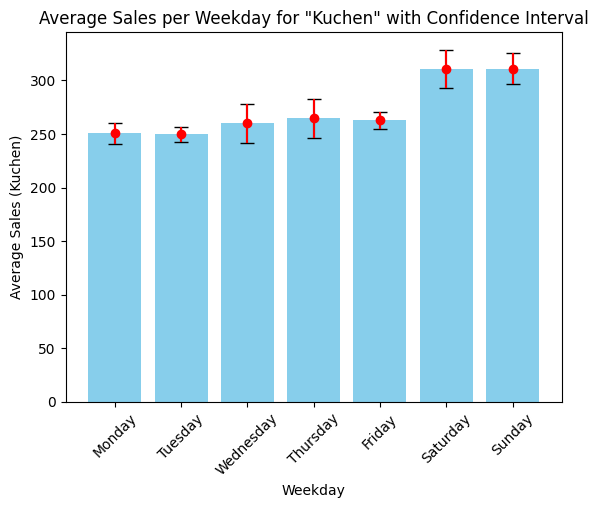

In [56]:
# Filter the DataFrame to keep only the rows where 'Kuchen' equals 1
df_kuchen = df_warengruppe_new[df_warengruppe_new['Kuchen'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_kuchen['Datum'] = pd.to_datetime(df_kuchen['Datum'])

# Extract weekday from 'Datum' column in place
df_kuchen['Weekday'] = df_kuchen['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Kuchen' column
avg_sales_per_weekday = df_kuchen.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval
ci = 1.96 * df_kuchen.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_kuchen.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Brot' column
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Kuchen)')
plt.title('Average Sales per Weekday for "Kuchen" with Confidence Interval')
plt.show()

# Assign the modified DataFrame back to the variable `df_brot`
df_kuchen = df_kuchen.reset_index(drop=True)

# Print the updated DataFrame
# print(df_kuchen.head())
# logging.info(avg_sales_per_weekday)

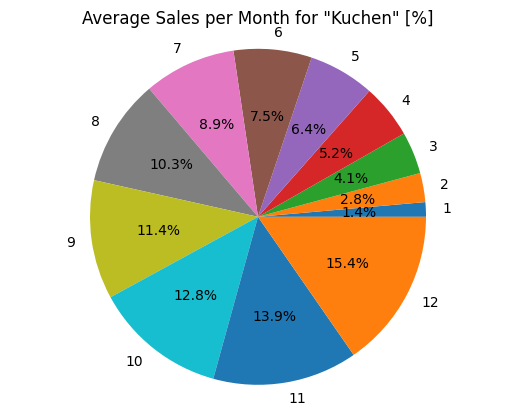

In [57]:
# Filter the DataFrame to keep only the rows where 'Kuchen' equals 1
df_kuchen = df_warengruppe_new[df_warengruppe_new['Kuchen'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_kuchen['Datum'] = pd.to_datetime(df_kuchen['Datum'])

# Extract month from 'Datum' column
df_kuchen['Month'] = df_kuchen['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_kuchen.groupby('Month')['Umsatz'].sum().cumsum().div(df_kuchen['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Kuchen" [%]')
plt.show()

#### **2.6 - List/Analyze the  column "Warengruppe - *Saisonbrot*"**

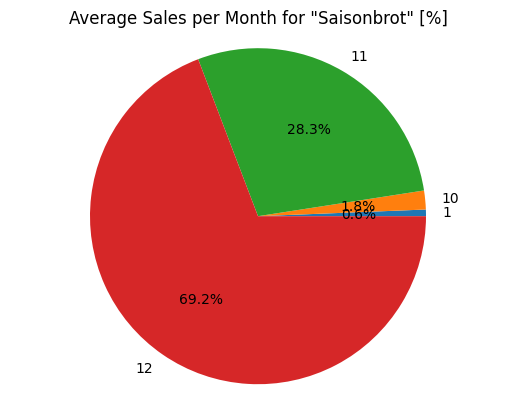

In [58]:
# Filter the DataFrame to keep only the rows where 'Saisonbrot' equals 1
df_saisonbrot = df_warengruppe_new[df_warengruppe_new['Saisonbrot'] == 1].copy()

# Convert 'Datum' column to datetime format in place
df_saisonbrot['Datum'] = pd.to_datetime(df_saisonbrot['Datum'])

# Extract month from 'Datum' column
df_saisonbrot['Month'] = df_saisonbrot['Datum'].dt.month

# Calculate the percentage of total sales for each month
monthly_sales = df_saisonbrot.groupby('Month')['Umsatz'].sum().cumsum().div(df_saisonbrot['Umsatz'].sum()).reset_index(name='Percentage')

# Plot the data using Matplotlib as a pie chart
fig, ax = plt.subplots()
ax.pie(monthly_sales['Percentage'], labels=monthly_sales['Month'], autopct='%1.1f%%')
ax.axis('equal')

ax.set_title('Average Sales per Month for "Saisonbrot" [%]')
plt.show()

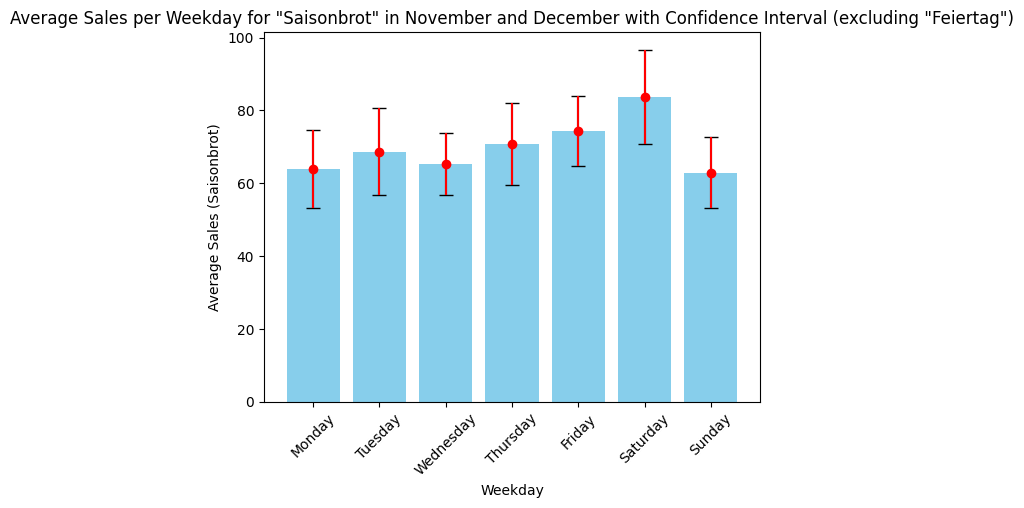

In [61]:
# Filter the DataFrame to keep only the rows where 'Saisonbrot' equals 1 and 'Month' is in ['November', 'December'] and 'Feiertage' is not equal to '1'
df_november_december = df_saisonbrot[df_saisonbrot['Saisonbrot'] == 1] \
                           [df_saisonbrot['Month'].isin([11, 12])] \
                           [df_saisonbrot['Feiertage'].ne(1)]

# Convert 'Datum' column to datetime format in place
df_november_december['Datum'] = pd.to_datetime(df_november_december['Datum'])

# Extract weekday from 'Datum' column in place
df_november_december['Weekday'] = df_november_december['Datum'].dt.weekday

# Calculate average sales per weekday for the 'Saisonbrot' column in November and December
avg_sales_per_weekday = df_november_december.groupby('Weekday')['Umsatz'].mean()

# Sort weekdays from Monday to Sunday
avg_sales_per_weekday = avg_sales_per_weekday.reindex([0, 1, 2, 3, 4, 5, 6])

# Calculate confidence interval for November and December
ci = 1.96 * df_november_december.groupby('Weekday')['Umsatz'].std() / np.sqrt(df_november_december.groupby('Weekday')['Umsatz'].count())

# Plot bar chart for the 'Saisonbrot' column in November and December
plt.bar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, capsize=5, color='skyblue')
plt.errorbar(avg_sales_per_weekday.index, avg_sales_per_weekday.values, yerr=ci.values, fmt='o', color='red')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation = 45)
plt.xlabel('Weekday')
plt.ylabel('Average Sales (Saisonbrot)')
plt.title('Average Sales per Weekday for "Saisonbrot" in November and December with Confidence Interval (excluding "Feiertag")')
plt.show()

# Assign the modified DataFrame back to the variable `df_saisonbrot`
df_saisonbrot = df_november_december.reset_index(drop=True)

# Print the updated DataFrame
# print(df_saisonbrot.head())
# logging.info(avg_sales_per_weekday)

#### **3 - Overall evaluation "*Warengruppe* - *Days of the Week*"**

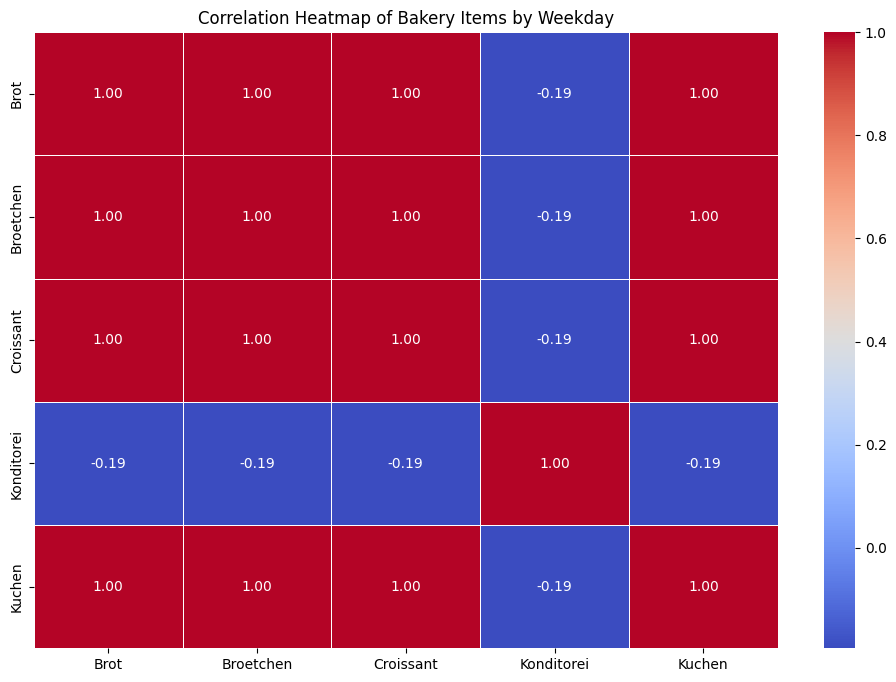

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correct URL for the new file
url_new = 'https://raw.githubusercontent.com/BossyNine/bakery_sales_prediction/main/sourcedata/cleaned_data/5-1_has_wettercode_single_warengruppen.csv'

# Read the file and check it out
df_warengruppe_new = pd.read_csv(url_new)

# Convert 'Datum' column to datetime format
df_warengruppe_new['Datum'] = pd.to_datetime(df_warengruppe_new['Datum'])

# Extract the weekday from 'Datum' column
df_warengruppe_new['Weekday'] = df_warengruppe_new['Datum'].dt.weekday

# Select columns from 'Brot' to 'Saisonbrot'
selected_columns = df_warengruppe_new.iloc[:, 9:14]

# Group by 'Weekday' and the bakery items, then calculate the mean sales
grouped_data = df_warengruppe_new.groupby('Weekday')[['Brot', 'Broetchen', 'Croissant', 'Konditorei', 'Kuchen']].mean()

# Reset index to flatten the DataFrame
grouped_data = grouped_data.reset_index()

# Calculate the correlation matrix for the bakery items by weekday
correlation_matrix = grouped_data.iloc[:, 1:].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Heatmap of Bakery Items by Weekday')
plt.show()


Key Insights:
Perfect Correlation (1.00):

The sales of Brot, Broetchen, Croissant, and Kuchen are perfectly correlated with each other (correlation coefficient of 1.00). This indicates that the sales patterns for these items are highly similar across weekdays. When the sales of one of these items increase or decrease, the sales of the others follow the same trend.
Moderate Negative Correlation (-0.19):

Konditorei has a moderate negative correlation with Brot, Broetchen, Croissant, and Kuchen (correlation coefficients of -0.19). This suggests that there is some inverse relationship, indicating that when the sales of Konditorei items increase, the sales of the other items tend to decrease slightly, and vice versa.

### **4 - Overview of all the missing dates in the 'Datum' column between 2013-07-01 and 2018-07-30 (plus weekdays for interpretation)**

In [ ]:
# Read the file and check it out
# df = pd.read_csv(r'/Users/jberndt/Desktop/2-2-opencampus/X-opencampus_ML/2_DS_and_ML/5-homework_week05/z-data_sorted-v1/5_has_wettercode.csv')

# Correct URL
url = 'https://raw.githubusercontent.com/BossyNine/bakery_sales_prediction/main/sourcedata/cleaned_data/5_has_wettercode.csv'

# Read the file and check it out
df = pd.read_csv(url)
df.info()
df

In [ ]:
# Convert the 'Datum' column to a datetime object:
df['Datum'] = pd.to_datetime(df['Datum'])

# Check for missing dates:
missing_dates = pd.date_range(start=df['Datum'].min(), end=df['Datum'].max()).difference(df['Datum'])

# Convert the 'DatetimeIndex' object to a 'Series' object:
missing_dates = missing_dates.to_series()

# Write the missing dates to a new CSV file:
missing_dates.to_csv('missing_dates.csv', header=False, index=False)

# Read the file and check it out
df = pd.read_csv(r'/Users/jberndt/Desktop/2-2-opencampus/X-opencampus_ML/2_DS_and_ML/5-homework_week05/missing_dates.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   2013-07-02  495 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB


,2013-07-02
0,2013-07-05
1,2013-07-06
2,2013-07-07
3,2013-07-09
4,2013-07-12
...,...
490,2018-07-12
491,2018-07-17
492,2018-07-19
493,2018-07-23


In [ ]:
df = pd.read_csv(r'/Users/jberndt/Desktop/2-2-opencampus/X-opencampus_ML/2_DS_and_ML/5-homework_week05/missing_dates.csv')
df['Datum'] = pd.to_datetime(df['Datum'])
df['Day_of_Week'] = df['Datum'].dt.day_name()
df.to_csv('missing_dates_plus.csv', index=False)

# Read the file and check it out
df = pd.read_csv(r'/Users/jberndt/Desktop/2-2-opencampus/X-opencampus_ML/2_DS_and_ML/5-homework_week05/missing_dates_plus.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Datum        496 non-null    object
 1   Day_of_Week  496 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


,Datum,Day_of_Week
0,2013-07-02,Tuesday
1,2013-07-05,Friday
2,2013-07-06,Saturday
3,2013-07-07,Sunday
4,2013-07-09,Tuesday
...,...,...
491,2018-07-12,Thursday
492,2018-07-17,Tuesday
493,2018-07-19,Thursday
494,2018-07-23,Monday
